In [1]:
# 주식 종목 불러오는 패키지
!pip install finance-datareader

  Obtaining dependency information for finance-datareader from https://files.pythonhosted.org/packages/f2/e4/cfc7d63d8d93306537b5a9b256006acc5172373293bef15e84d6741ab839/finance_datareader-0.9.101-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/50.0 kB ? eta -:--:--
   ---------------------------------------- 50.0/50.0 kB 2.5 MB/s eta 0:00:00


In [2]:
import FinanceDataReader as fdr

# 삼성전자

In [3]:
# 삼성전자로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005930', '2022-01-01', '2025-12-31')
df.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2025-12-23,110900,112500,110400,111500,20419187,0.009050
2025-12-24,112400,112400,110900,111100,12492939,-0.003587
2025-12-26,112400,117000,112400,117000,34018174,0.053105
2025-12-29,119400,119700,118200,119500,19676004,0.021368
2025-12-30,119100,121200,118700,119900,19746349,0.003347


# 분석 코드

In [28]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# GPU 꼭 연결해서 사용하세요~!
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

c:\Users\82107\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\82107\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


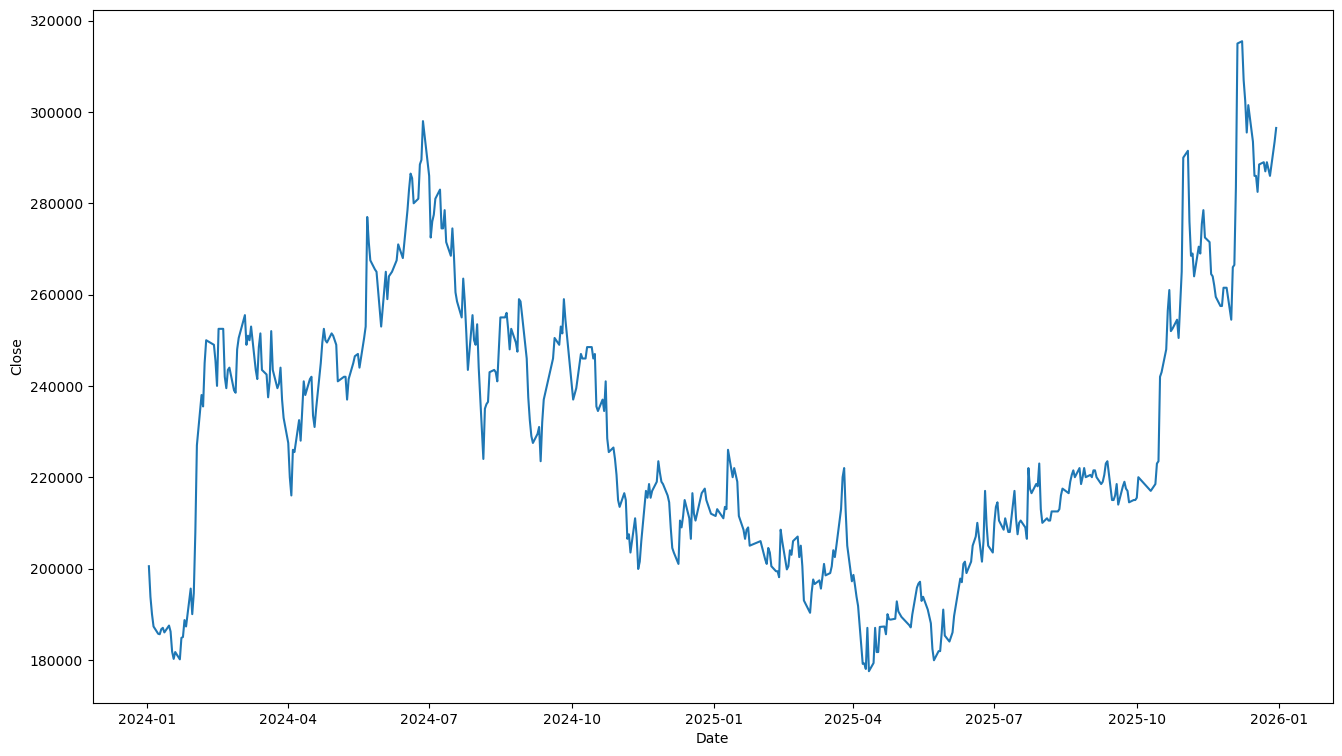

In [30]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y='Close', data=df)
plt.show()

# 데이터 전처리

In [31]:
#스케일링 (반응변수 = 종가)
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Volume']])

In [32]:
scaler_y = MinMaxScaler()
df[['Close']] = scaler_y.fit_transform(df[['Close']])

In [34]:
#넘파이 배열로 변경
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

#시퀀스 데이터 생성
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length])
    y_seq.append(y[i + sequence_length])

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [35]:
split = int(len(df) * 0.7)
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#순서대로 70개는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([340, 5, 4]) torch.Size([340, 1])
torch.Size([141, 5, 4]) torch.Size([141, 1])


In [36]:
x_train_seq

tensor([[[0.1707, 0.1578, 0.1809, 0.0262],
         [0.1505, 0.1365, 0.1356, 0.0575],
         [0.1010, 0.0888, 0.1002, 0.0499],
         [0.0878, 0.0725, 0.0859, 0.0382],
         [0.0704, 0.0611, 0.0731, 0.0174]],

        [[0.1505, 0.1365, 0.1356, 0.0575],
         [0.1010, 0.0888, 0.1002, 0.0499],
         [0.0878, 0.0725, 0.0859, 0.0382],
         [0.0704, 0.0611, 0.0731, 0.0174],
         [0.0718, 0.0533, 0.0731, 0.0219]],

        [[0.1010, 0.0888, 0.1002, 0.0499],
         [0.0878, 0.0725, 0.0859, 0.0382],
         [0.0704, 0.0611, 0.0731, 0.0174],
         [0.0718, 0.0533, 0.0731, 0.0219],
         [0.0564, 0.0498, 0.0708, 0.0187]],

        ...,

        [[0.0341, 0.0156, 0.0264, 0.1075],
         [0.0181, 0.0192, 0.0294, 0.0709],
         [0.0223, 0.0114, 0.0339, 0.0493],
         [0.0341, 0.0426, 0.0497, 0.0687],
         [0.0843, 0.0903, 0.0791, 0.1544]],

        [[0.0181, 0.0192, 0.0294, 0.0709],
         [0.0223, 0.0114, 0.0339, 0.0493],
         [0.0341, 0.0426, 0.0497

In [37]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

# Vanila RNN
## 모델 구축

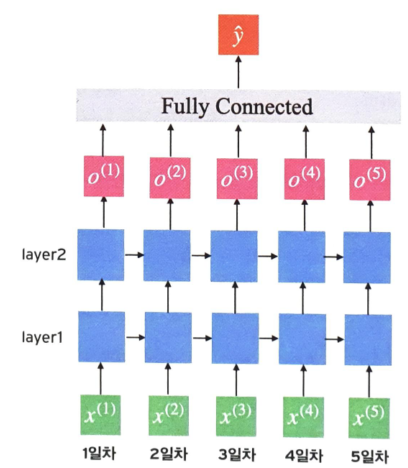

In [38]:
#기본 하이퍼 파라미터 설정
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [39]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) #한 줄로 모델 정의
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid()) #RNN 층에서 나온 결과를 fc 층으로 전달해서 예측값 계산

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #초기값 0으로 설정
    out,_ = self.rnn(x, h0)
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [40]:
model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [41]:
criterion = nn.MSELoss()
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 모델 학습

In [42]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.0419
[epoch : 10] loss: 0.0043
[epoch : 20] loss: 0.0031
[epoch : 30] loss: 0.0028
[epoch : 40] loss: 0.0026


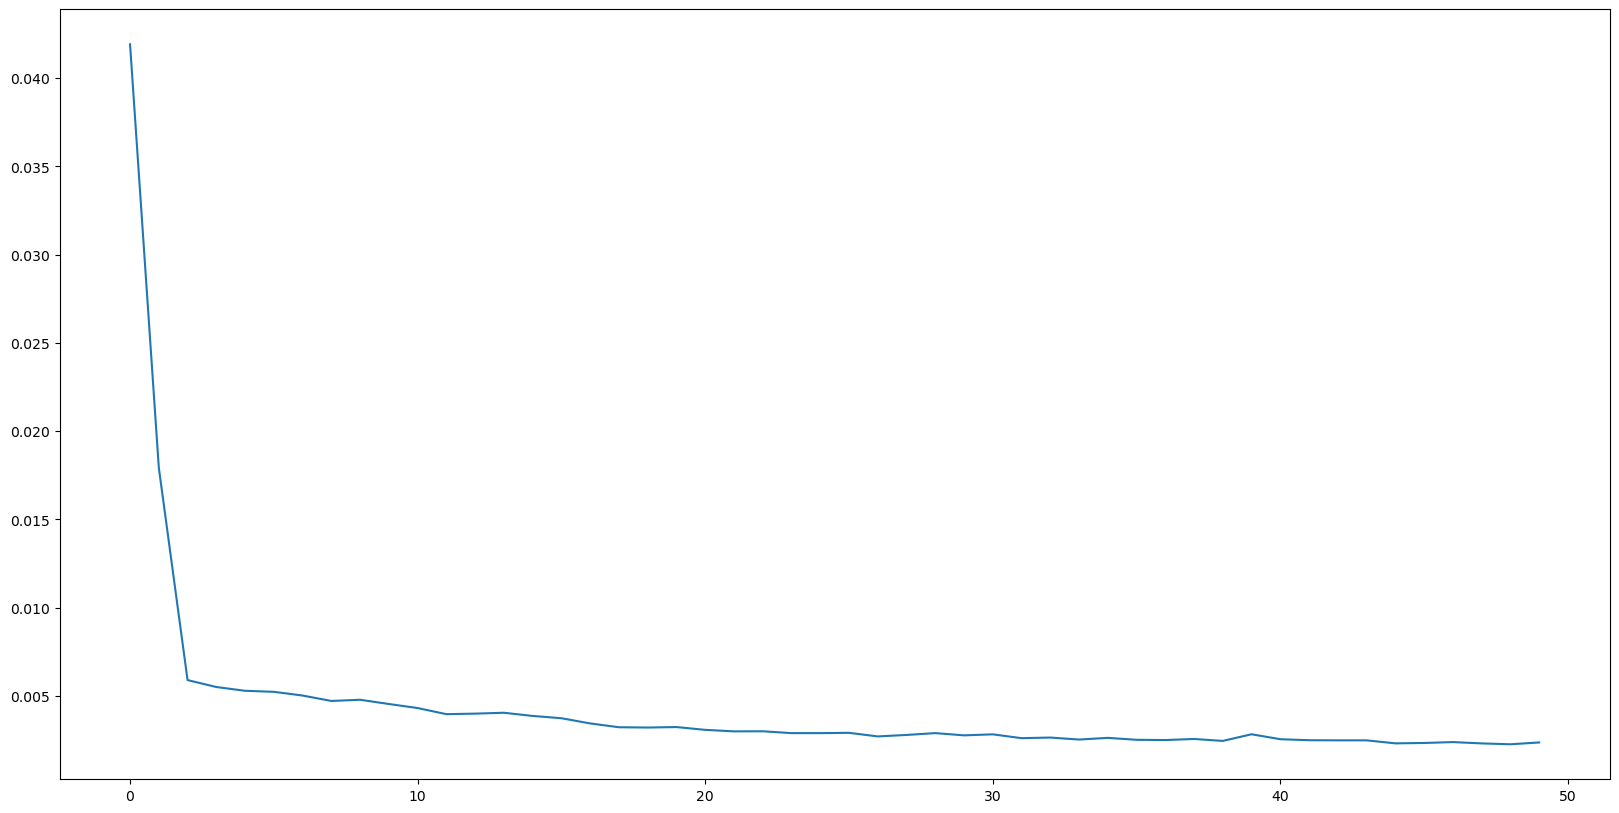

In [43]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

## 실제값과 예측값 비교

In [44]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad():
  pred = []
  model.eval()
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist()

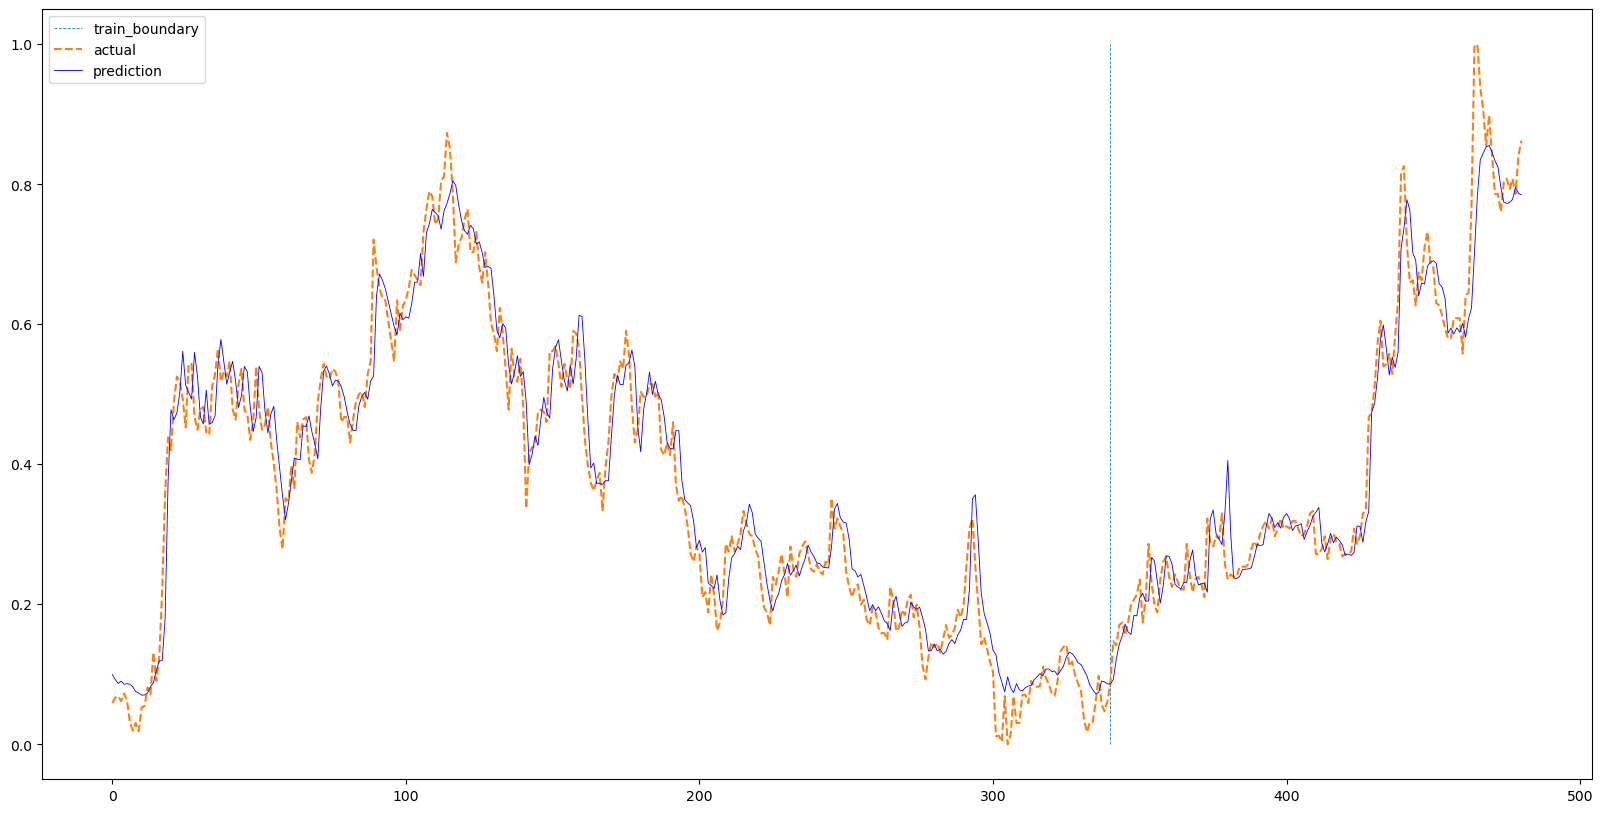

In [45]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()

# LSTM
## 모델구축

In [46]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [49]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length ,1)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.lstm(x,(h0,c0))
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [50]:
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

In [51]:
criterion = nn.MSELoss()
num_epochs =50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [52]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))


[epoch: 0] loss: 0.0964
[epoch: 10] loss: 0.0047
[epoch: 20] loss: 0.0041
[epoch: 30] loss: 0.0031
[epoch: 40] loss: 0.0026


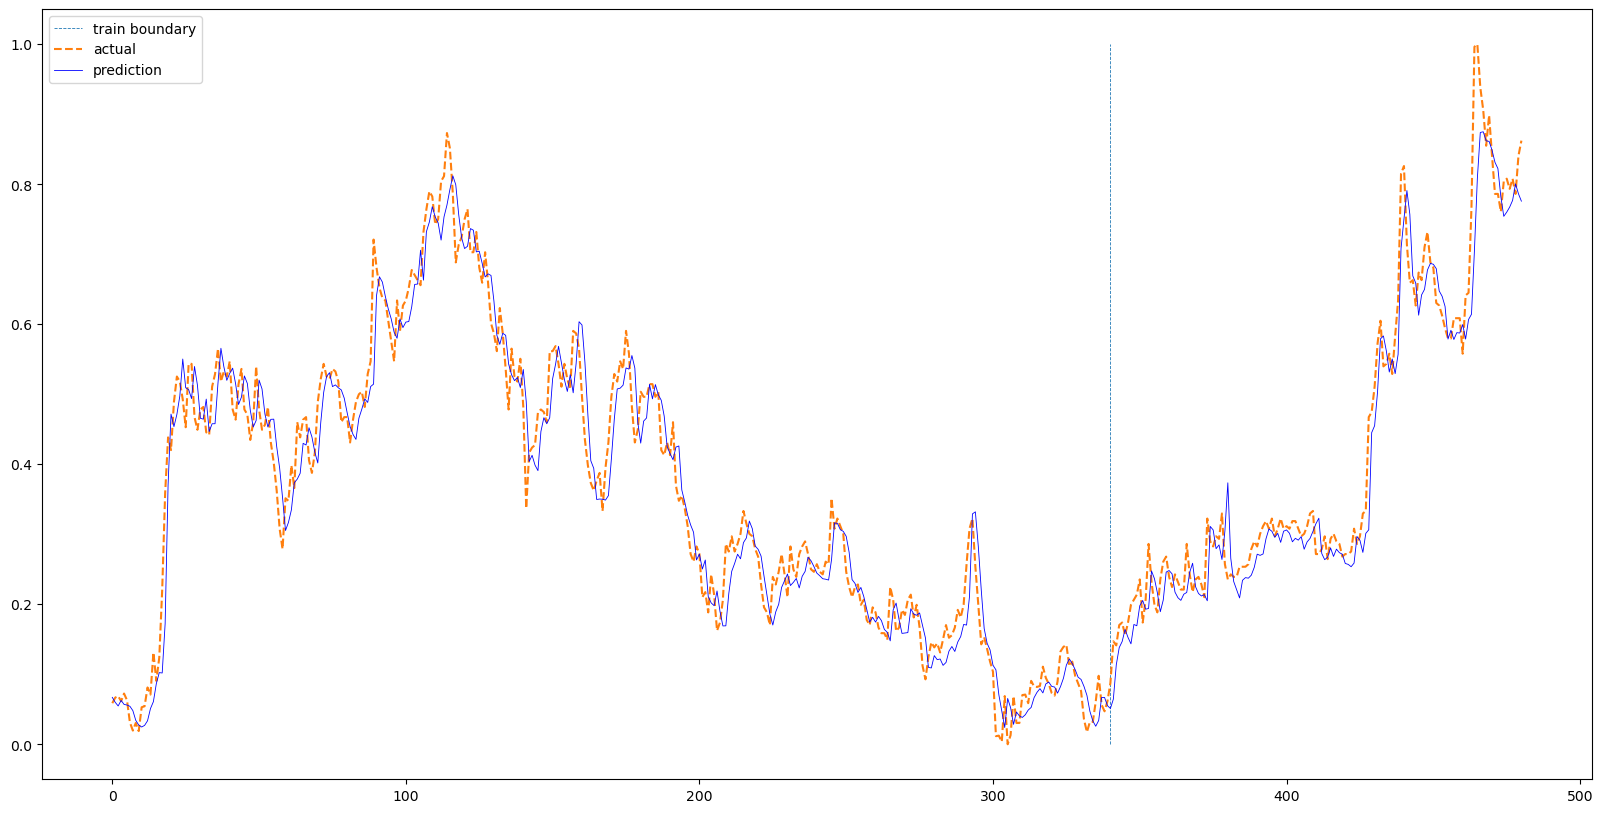

In [53]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()

# Q1.

현대 자동차 주가에 대한 정보에 같은 분석을 해봅시다. 다음 코드를 한 번 실행한 뒤, 분석 코드부터 다시 돌려보고 분석 결과에 대해 자유롭게 해석해보시기 바랍니다.
- 실제 주가 예측에서 사용할 때 어떤 문제가 발생할까요?
- 코드 어느 부분에서 데이터 누수가 우려되나요?
- MSE는 적절한 지표였을까요?

1. train loadoer에서 shuffle = true로 두면 미래의 값을 미리 입력으로 받는 경우가 생겨 학습이 제대로 이루어지지 않는다.
2. minmax scaler를 사용할 때 min,max값은 시간에 따라 변할텐데, 이는 입력 데이터의 스케일링의 일관성을 떨어트려서 time trend가 존재하는 경우에 대해서 보델이 강건하지 못 하다.
3. mse는 스케일링에 강건하지 못 하다. 즉, 같은 오차율이더라도 수준(scale)이 높은 수에 오차에 대해서 더 큰 패널티를 부과한다. 이는 상대적으로 스케일이 낮은 과거의 변수 예측을 제대로 학습하지 못 하는 효과가 있다. 따라서 lossfunction 자체를 "오차율"로 계산한다면 성능이 더 향상될 것으로 예상된다.

In [27]:
# 현대자동자 주가로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005380', '2024-01-01', '2025-12-31')
df.tail

<bound method NDFrame.tail of               Open    High     Low   Close   Volume    Change
Date                                                         
2024-01-02  202000  202500  199800  200500   373050 -0.014742
2024-01-03  199100  199500  193800  193800   548675 -0.033416
2024-01-04  192000  192800  189100  190000   505979 -0.019608
2024-01-05  190100  190500  187200  187300   440219 -0.014211
2024-01-08  187600  188900  185500  185700   323498 -0.008542
...            ...     ...     ...     ...      ...       ...
2025-12-23  290500  292500  285500  287000   699584 -0.006920
2025-12-24  289000  300000  287000  289000  1295368  0.006969
2025-12-26  292000  292000  285000  286000   847245 -0.010381
2025-12-29  284500  294000  282500  293500   697450  0.026224
2025-12-30  291000  297500  289500  296500   628188  0.010221

[486 rows x 6 columns]>